 
<h1 align="center">🚀 Advancing AI frontiers with Claude 3</h1>

----

## 🛠️ TLDR : Build 5 vision and text use cases with Claude 3 Sonnet on Amazon Bedrock:


- **1. Q&A with an AWS Architecture diagram** :
Learn how to integrate Claude 3 Sonnet into your AWS architecture to enhance AI capabilities. 🏗️

- **2 Automate Terraform script from AWS architecture diagram**:
Learn how to build a Terraform deployment with AWS architecture images using Claude 3 Sonnet. 🛠️

- **3. Side by Side Image Comparison**:
Discover the power of image comparison using Claude 3 Sonnet on Amazon Bedrock. 🖼️

- **4. Image Transcription**:
Explore the capabilities of image transcription with Claude 3 Sonnet on Amazon Bedrock. 📝

- **5. Streaming text reponse**:
Understand how to use Claude 3 Sonnet for streaming text responses. 📜

---

### Introduction to Claude 3

Anthropic unveils the Claude 3 model family, featuring Haiku, Sonnet, and Opus. 🌐

These models redefine AI capabilities, catering to diverse needs. Claude 3 Sonnet is available for immediate use on Amazon Bedrock, with Claude 3 Opus and Claude 3 Haiku coming soon. 💻

Claude 3 Sonnet strikes the ideal balance between intelligence and speed—particularly for enterprise workloads. It delivers robust performance at a lower cost compared to its peers and is engineered for high endurance in large-scale AI deployments. Moreover, it introduces image-to-text vision capabilities! 📸

**Potential uses**:
- Data processing: RAG or search & retrieval over vast amounts of knowledge 📚
- Sales: product recommendations, forecasting, targeted marketing 📈
- Time-saving tasks: code generation, quality control, parse text from images ⏰

**Differentiator**: More affordable than other models with similar intelligence; better for scale. 💰

**Key features**:

- 📊 **Context Window:** 200,000 tokens

- ⚡ **Speed:** 2x faster than Claude 2 and Claude 2.1

- 👁️ **Vision Capabilities:** Handles a wide range of visual formats, including photos, charts, graphs, and technical diagrams.

- 🚫 **Refusals:** Claude 3 models (including Sonnet) significantly reduce unnecessary refusals compared to previous generations.

- 🛡️ **Safety Level:** Maintains AI Safety Level 2 (ASL-2) per the Responsible Scaling Policy.

- 🚀 **Model Speed Comparison:** Sonnet is 2x faster than Claude 2 and Claude 2.1, excelling at tasks demanding rapid responses.


### Pre-requisites:

- **AWS Account**: To use Amazon Bedrock and deploy the use cases.
- **AWS Credentials**: Make sure your credientials are configured in your environment. More details [here](https://handsonaws.com/blog/advanced-awscli-notebooks-iam-s3-cross-account/)

If you have a AWS profile configured in your environment, you can use the following magic commands to set the profile and rehash the environment variables:

```bash 
%env AWS_PROFILE = your_profile
%rehashx
%automagic 1
```
- **Amazon Bedrock permissions** : Amazon Bedrock IAM permissions to run this notebook. More details [here](https://docs.aws.amazon.com/bedrock/latest/userguide/iam-permissions.html)

Enable AWS IAM permissions for Bedrock
The AWS identity you assume from your notebook environment (which is the Studio/notebook Execution Role from SageMaker, or could be a role or IAM User for self-managed notebooks), must have sufficient AWS IAM permissions to call the Amazon Bedrock service.

To grant Bedrock access to your identity, you can:

Open the AWS IAM Console
Find your Role (if using SageMaker or otherwise assuming an IAM Role), or else User
Select Add Permissions > Create Inline Policy to attach new inline permissions, open the JSON editor and paste in the below example policy:


```json 
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Sid": "BedrockFullAccess",
            "Effect": "Allow",
            "Action": ["bedrock:*"],
            "Resource": "*"
        }
    ]
}
```



### Use case 1: Q&A with an AWS Architecture diagram using Claude 3 Sonnet on Amazon Bedrock

In this use case, we will explore how to integrate Claude 3 Sonnet to help you answer questions about your AWS architecture. This can be particularly useful for large-scale deployments, where it can be challenging to keep track of all the moving parts.




In [ ]:
# Install latest version of boto3
!pip install boto3==1.33.2 termcolor matplotlib ipython


In [28]:
import base64, re,json
import boto3
from termcolor import colored
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
from IPython.display import display, Image


In [29]:
def image_to_base64(image_path):
    with open(image_path, 'rb') as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')


def display_image(image_path):
    with open(image_path, "rb") as image_file:
        display(Image(data=image_file.read()))

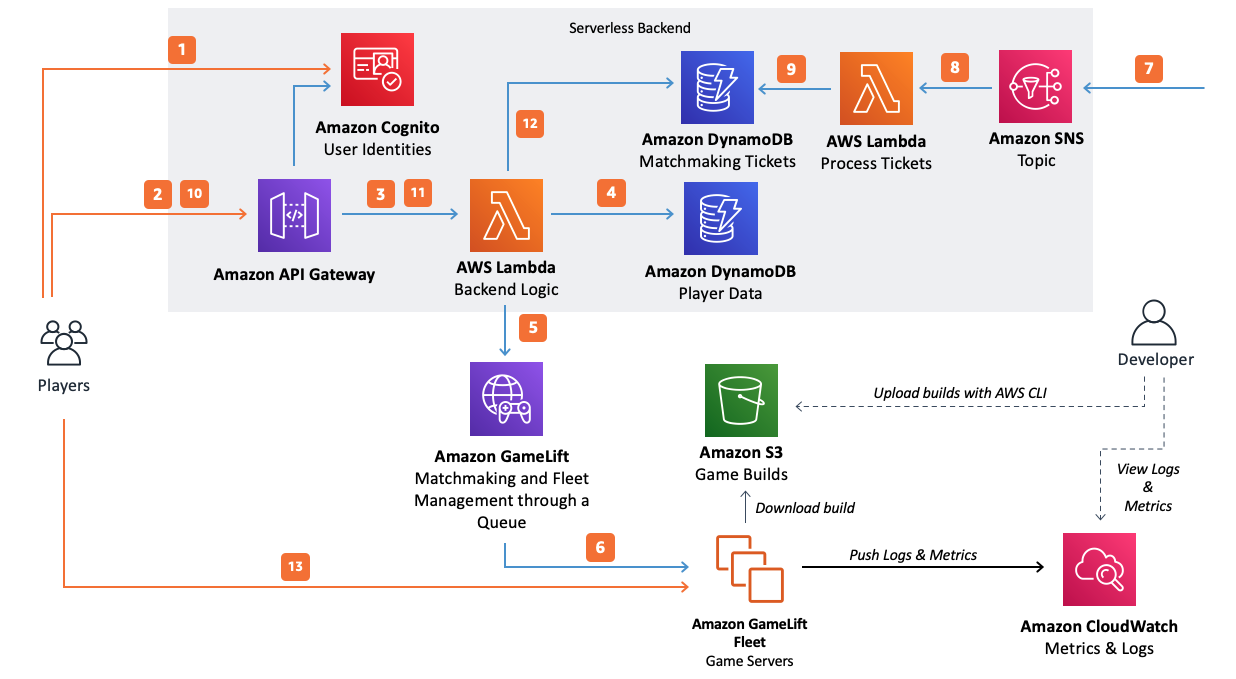

In [30]:
display_image("images/architecture.png")

The Claude 3 family of models comes with new vision capabilities that allow Claude to understand and analyze images, opening up exciting possibilities for multimodal interaction. With Claude, you can now provide both text and image inputs to enrich your conversations and enable powerful new use cases.


To utilize images when making an API request, you can provide images to Claude as a ``base64-encoded`` image in image content blocks. Here is simple example in Python showing how to include a base64-encoded image in a Messages API request:

```python
messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "source": {
                        "type": "base64",
                        "media_type": image1_media_type,
                        "data": image1_data,
                    },
                },
                {
                    "type": "text",
                    "text": "Describe this image."
                }
            ],
        }
    ],
```

Supported image formats are ``JPEG, PNG, GIF, and WebP``. See Messages [API examples](https://docs.anthropic.com/claude/reference/messages_post) for more example code and parameter details.

Below we defined two funtions to help you get started with image processing using Claude 3 Sonnet on Amazon Bedrock:

- ``post_process_answer()`` : This function extracts answer from the Bedrock API response. A best pratice frome [Claude prompt engineering](https://docs.anthropic.com/claude/docs/prefill-claudes-response) is to output the answer inside <answer></answer> XML tags. This function will extract the answer from the API response.
- ``generate_vision_answer()`` : This function will generate the API request to send the image to the Claude 3 Sonnet model to Amazon Bedrock. 




In [ ]:
def post_process_answer(response:str)->str:
    """
    Extracts the answer from the given response string.

    Args:
        response (str): The response string containing the answer.

    Returns:
        str: The extracted answer.
    """
    answer = re.findall(r'<answer>(.*?)</answer>', response, re.DOTALL)
    return answer[0]

def generate_vision_answer(bedrock_rt:boto3.client,messages:list, model_id:str, claude_config:dict,system_prompt:str):
    """
    Generates a vision answer using the specified model and configuration.
    
    Parameters:
    - bedrock_rt (boto3.client): The Bedrock runtime client.
    - messages (list): A list of messages.
    - model_id (str): The ID of the model to use.
    - claude_config (dict): The configuration for Claude.
    - system_prompt (str): The system prompt.
    
    Returns:
    - str: The formatted response.
    """
    
    body={'messages': [messages],**claude_config, "system": system_prompt}
    
    response = bedrock_rt.invoke_model(modelId=model_id, body=json.dumps(body))   
    response = json.loads(response['body'].read().decode('utf-8'))
    formated_response= post_process_answer(response['content'][0]['text'])
    
    return formated_response

In this use case, the goal is to ask a question about the AWS architecture and provide an image of the architecture. The image will be sent to the Claude 3 Sonnet model to generate a response. The response will be post-processed to extract the answer.

To perform this task, we need a **system prompt**. This is a way of providing context and instructions to Claude, such as specifying a particular goal or role. See our guide to system prompts.

An example system prompt for this use case could be:

```
You have perfect vision and pay great attention to detail which makes you an expert at answering architecture diagram question
```

In [ ]:
%%time

# Create a bedrock runtime client in us-west-2
bedrock_rt = boto3.client("bedrock-runtime", region_name="us-west-2")



# Model id and claude config
model_id = "anthropic.claude-3-sonnet-20240229-v1:0"
claude_config = {
    'max_tokens': 1000, 
    'temperature': 0, 
    'anthropic_version': '',  
    'top_p': 1, 
    'stop_sequences': ['Human:']
}

# Create prompt and system prompt
system_prompt= "You have perfect vision and pay great attention to detail which makes you an expert at answering architecture diagram question. Answer question in <question></question> tags. Before answer, think step by step in <thinking> tags and analyze every part of the diagram."

#Create a prompt with the question
prompt = f"<question>Explain why Amazon Gamelift is usefull on the diagram </question>. Answer must be a numbered list in a small paragraph inside <answer></answer> tag."

# Create message with the prompt and the base64 encoded image
messages={"role": "user", "content": [
{
        "type": "image",
        "source": {
        "type": "base64",
        "media_type": "image/jpeg",
        "data": image_to_base64("images/architecture.png"),
        }
},
{"type": "text", "text": prompt}
]}

# Generate answer
answer=generate_vision_answer(bedrock_rt, messages, model_id, claude_config, system_prompt)    
print(colored(answer, "green"))


### Use Case 2: Automate Terraform script from AWS architecture diagram using Claude 3 Sonnet on Amazon Bedrock

In this use case, we will explore how to use Claude 3 Sonnet to generate a Terraform script from an AWS architecture image. This can be particularly useful for automating the deployment of AWS infrastructure. It will greatly reduce the time and effort required to create Terraform scripts from AWS architecture images.


Here is a simple serveless architectiure diagram that we will use as an example:


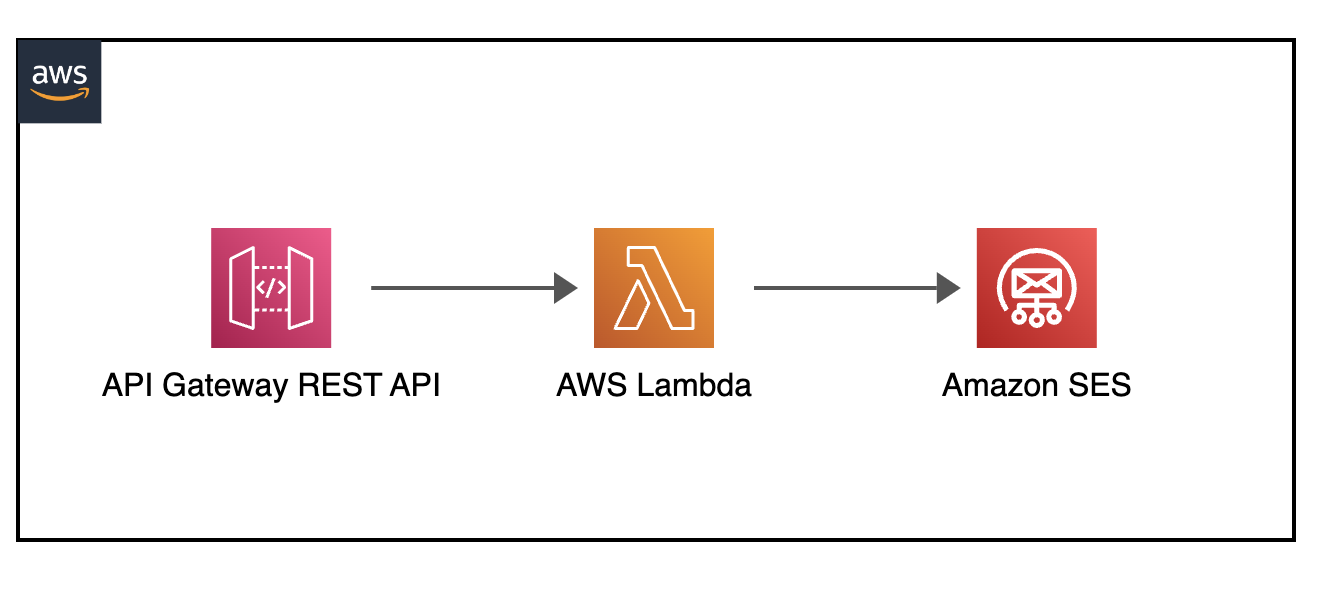

In [31]:
display_image("images/serverless.png")

In [ ]:
system_prompt=""
messages = {    
    "role": "user",
    "content": [
        {
            "type": "image",
            "source": {
                "type": "base64",
                "media_type": "image/jpeg",
                "data": image_to_base64("images/serverless.png")
            }
        },
        {
            "type": "text",
            "text": "Describe the architecture and code terraform script to deploy it, answer inside <answer></answer> tags."
        }
    ]
}

# Generate answer
answer= generate_vision_answer(bedrock_rt, messages, model_id, claude_config, system_prompt="")
print(colored(answer, "green"))

### Use case 3:  Side by side image comparaison using Claude 3 Sonnet on Amazon Bedrock

In this use case, we will explore how to use Claude 3 Sonnet to compare two images side by side. This can be particularly useful for quality control and identifying differences between two images.

#### Let's play a game!

Can you spot the differences between the two images below?


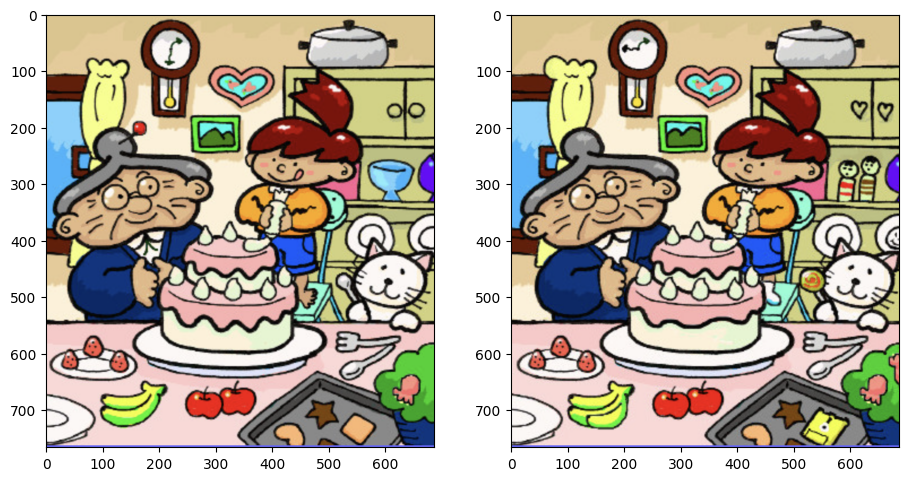

In [33]:
%matplotlib inline

local_images = ["images/image_1.png", "images/image_2.png"]

# figure size in inches optional
rcParams['figure.figsize'] = 11 ,8

# read images
img_A = mpimg.imread(local_images[0])
img_B = mpimg.imread(local_images[1])

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(img_A)
ax[1].imshow(img_B)

In [ ]:
%%time
import base64

list_images_base64 = []
local_images = ["images/image_1.png", "images/image_2.png"]


system_prompt="You have perfect vision and pay great attention to detail which makes you an expert at finding differences between images. Answer question in <question></question> tags, answer must be inside <answer></answer> tag. Before answer,  Think step by step in <thinking> tags and analyze every part of the image."
prompt="List all difference between the two pictures ?"
messages={"role": "user", "content": [
        {
                    "type": "text",
                    "text": "Image 1:"
            },
        {
            "type": "image",
            "source": {
                "type": "base64",
                "media_type": "image/jpeg",
                "data": image_to_base64(local_images[0]),
            }
        },
        {
            "type": "text",
            "text": "Image 2:"
        },
        {
            "type": "image",
            "source": {
                "type": "base64",
                "media_type": "image/jpeg",
                "data": image_to_base64(local_images[1]),
            }
        },
        {"type": "text", "text": prompt}
    ]}
# Generate answer
answer= generate_vision_answer(bedrock_rt, messages, model_id, claude_config, system_prompt)    
print(colored(answer, "green"))

### Use Case 4: Image Transcription with Claude 3 Sonnet on Amazon Bedrock 

In this use case, we will explore how to use Claude 3 Sonnet to transcribe text from an image. This can be particularly useful for extracting text from:

1. Images
2. Charts
3. Diagram
4. Technical Drawings


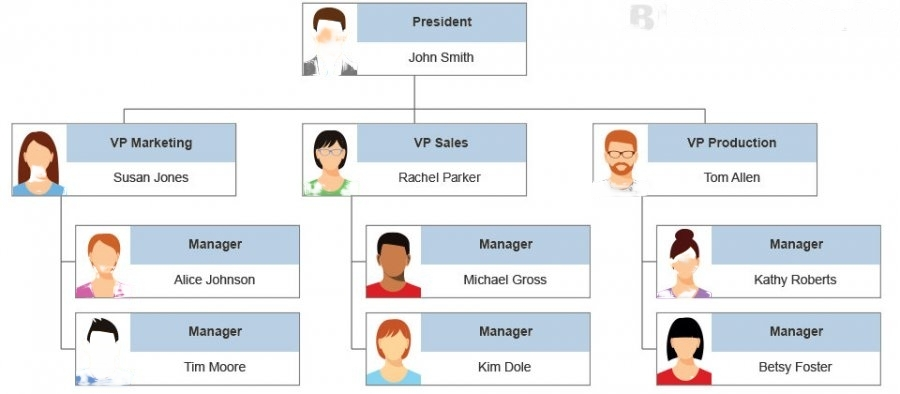

In [32]:
display_image("images/organigram.jpeg")

In [ ]:
messages = {
        "role": 'user',
        "content": [
            {"type": "image", "source": {"type": "base64", "media_type": "image/jpeg", "data": image_to_base64("images/organigram.jpeg")}},
            {"type": "text", "text": "Turn this org chart into JSON indicating who reports to who, answer inside <answer></answer> tags."}
        ]
    }

# Generate answer
answer= generate_vision_answer(bedrock_rt, messages, model_id, claude_config, system_prompt="")
print(colored(answer, "green"))

### Use Case 5: Streaming Text with Claude 3 Sonnet on Amazon Bedrock

In this use case, we'll explore how to harness the power of Claude 3 Sonnet to stream text. This functionality proves particularly beneficial for:

- Real-time updates
- Live conversations
- Dynamic content generation
- Continuous text processing


In [ ]:
#Streaming with Bedrock 3


def stream_answer(bedrock_rt:boto3.client, model_id:str, claude_config:dict, prompt:str):
    stream_answer={"role": "user", "content": prompt}
    
    body={'messages': [stream_answer],**claude_config}
    response = bedrock_rt.invoke_model_with_response_stream(modelId=model_id, body=json.dumps(body))
    response_stream = response.get('body')
    for event in response_stream or []:
        chunk_data = event.get('chunk')
        if chunk_data:
            chunk_obj = json.loads(chunk_data.get('bytes').decode())
            delta = chunk_obj.get('delta', {})
            text_content = delta.get('text', "")
            yield str(text_content)

In [ ]:
prompt="What is AWS ? Answer must be concise and to the point."

for answer in stream_answer(bedrock_rt, model_id, claude_config, prompt):
    print(answer,end="")

#### <span style="color:#3498db">Optional: Put Words in Claude's Mouth</span>

**Why prefill Claude's response?**

Prefilling Claude's response offers several key benefits:
- **Increased steerability**: By providing some initial text for Claude to continue from, you can steer Claude's response in a desired direction. This is particularly useful when you want Claude to focus on a specific topic, generate a particular type of content, or act a certain way.

- **Control output format**: Prefilling allows you to specify the exact format you want Claude to use for its output. This is especially handy when working with structured data formats like JSON or XML. For more details on this, see our guide on controlling output format.

- **Maintain character consistency**: In role-play scenarios, prefilling Claude's response can help Claude stay in character throughout a long conversation. By consistently reminding Claude of its role in the Assistant message, you can better ensure that Claude maintains the desired persona. Check out keep Claude stay in character for more details.


In [ ]:

def generate_answer(bedrock_rt:boto3.client, prompt:str, model_id:str, claude_config:dict,system_prompt:str)->str:
    

    message={'messages': [{"role": "user", "content": prompt},
                          {"role": "assistant", "content": "The answer is"}]}
    
    body={**message,**claude_config, "system": system_prompt}
    
    response = bedrock_rt.invoke_model(modelId=model_id, body=json.dumps(body))
    response = json.loads(response['body'].read().decode('utf-8'))
    return response['content'][0]['text']

In [ ]:
system_prompt="You are a biology student, answer following questions"
prompt="What is latin for Ant? (A) Apoidea, (B) Rhopalocera, (C) Formicidae"
response=generate_answer(bedrock_rt, prompt, model_id, claude_config,system_prompt)
print(response)